#### Шарова Елена

# Home assignment 2. VaR

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.api import SimpleExpSmoothing
from arch import arch_model

## Пункт 1. Доходности и статистика

In [235]:
df = pd.read_excel('PIKKData.xlsx', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df['Returns'] = df['Close'].pct_change()
df = df.dropna()
df

/var/folders/6p/8d5pp0rd4_sbkn9mzjsq45rr0000gn/T/ipykernel_74975/613268941.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_excel('PIKKData.xlsx', parse_dates=['Date'])


,Date,Open,High,Low,Close,Vol,Returns
1,2020-03-23,376.7,383.0,370.2,375.0,115400,-0.024454
2,2020-03-24,376.9,398.4,376.9,391.5,108270,0.044000
3,2020-03-25,393.4,409.8,393.4,402.5,134400,0.028097
4,2020-03-26,400.0,409.7,396.5,409.7,81390,0.017888
5,2020-03-27,407.8,408.3,402.3,406.0,60680,-0.009031
...,...,...,...,...,...,...,...
1250,2025-03-16,618.8,629.9,618.5,629.3,154118,0.019935
1251,2025-03-17,628.1,649.9,627.1,646.2,1750376,0.026855
1252,2025-03-18,647.5,657.4,627.1,628.4,2452605,-0.027546
1253,2025-03-19,629.4,648.2,622.0,640.1,2118989,0.018619


In [237]:
mean_daily = df['Returns'].mean()
std_daily = df['Returns'].std()
mean_annual = mean_daily * 252
std_annual = std_daily * np.sqrt(252)

summary_stats = pd.DataFrame({
    'Mean Daily': [mean_daily],
    'Std Daily': [std_daily],
    'Mean Annual': [mean_annual],
    'Std Annual': [std_annual]
})

summary_stats

,Mean Daily,Std Daily,Mean Annual,Std Annual
0,0.00074,0.025751,0.186594,0.40878


## Пункт 2. Разные подходы для рассчета волатильности

#### a. moving average, rolling window of 100 trading days

In [239]:
df['MA 100'] = df['Returns'].shift(1).rolling(window=100).std()

#### b. moving average, rolling window of 250 trading days

In [241]:
df['MA 250'] = df['Returns'].shift(1).rolling(window=250, min_periods=250).std()

#### c. EWMA

In [243]:
def ewma_volatility(returns, lambda_):
    var = np.zeros_like(returns)
    var[0] = np.var(returns[:100])  # Initial variance estimate
    for t in range(1, len(returns)):
        var[t] = lambda_ * var[t-1] + (1 - lambda_) * returns[t-1]**2
    return np.sqrt(var)

ewma_vol = ewma_volatility(df['Returns'].dropna().values, 0.94)
df.loc[df.index[100:100+len(ewma_vol[100:])], 'EWMA Vol'] = ewma_vol[100:]

#### d. GARCH (1,1)

In [245]:
garch_model = arch_model(df['Returns'].dropna() * 100, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
df['GARCH Vol'] = garch_result.conditional_volatility / 100

### Сравнение моделей

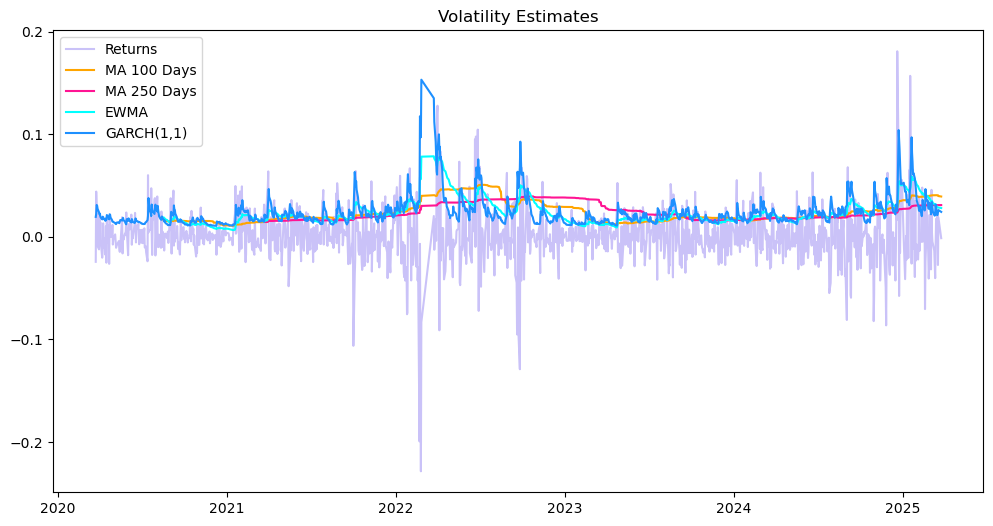

In [290]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Returns'], label = 'Returns', color = 'mediumslateblue', alpha = 0.4)
plt.plot(df['Date'], df['MA 100'], label = 'MA 100 Days', color = 'orange')
plt.plot(df['Date'], df['MA 250'], label = 'MA 250 Days', color = 'deeppink')
plt.plot(df['Date'], df['EWMA Vol'], label = 'EWMA', color = 'aqua')
plt.plot(df['Date'], df['GARCH Vol'], label = 'GARCH(1,1)', color = 'dodgerblue')
plt.legend()
plt.title('Volatility Estimates')
plt.show()

Комментарий: EWMA и GARCH(1,1) кажутся более гибкими и лучше реагируют на шоки в отличие от MA. 
Я бы предпочла модель GARCH(1,1)

В то же время, на лекции обсуждали, что более сложная модель не значит более хорошая модель, и в риск-менеджменте даже чаще выбирают EWMA (лекция 2, слайд 5). Чем больше параметров, которые надо оценить, тем больше estimation error.

## Пункт 3. VaR

#### a. Historical modeling with 1 year estimation period

In [251]:
def historical_var(returns, window, confidence_level=0.05):
    var = np.zeros_like(returns)
    for t in range(window, len(returns)):
        var[t] = np.percentile(returns[t-window:t], 100 * confidence_level)  
    return var

df['VaR Historical'] = historical_var(df['Returns'].values, 252)

#### b. Delta-normal approach using volatility estimated as moving average over 100 days

In [249]:
df['VaR 100'] = norm.ppf(0.05) * df['MA 100']

#### c.	Delta-normal approach using volatility estimated as moving average over 250 days

In [265]:
df['VaR 250'] = norm.ppf(0.05) * df['MA 250']

#### d.	Delta-normal approach using volatility estimated as EWMA

In [262]:
df['VaR EWMA'] = norm.ppf(0.05) * df['EWMA Vol']

In [267]:
df

,Date,Open,High,Low,Close,Vol,Returns,MA 100,MA 250,EWMA Vol,GARCH Vol,VaR 100,VaR Historical,VaR 250,VaR EWMA
1,2020-03-23,376.7,383.0,370.2,375.0,115400,-0.024454,NaN,NaN,NaN,0.019339,NaN,0.000000,NaN,NaN
2,2020-03-24,376.9,398.4,376.9,391.5,108270,0.044000,NaN,NaN,NaN,0.022416,NaN,0.000000,NaN,NaN
3,2020-03-25,393.4,409.8,393.4,402.5,134400,0.028097,NaN,NaN,NaN,0.030961,NaN,0.000000,NaN,NaN
4,2020-03-26,400.0,409.7,396.5,409.7,81390,0.017888,NaN,NaN,NaN,0.030225,NaN,0.000000,NaN,NaN
5,2020-03-27,407.8,408.3,402.3,406.0,60680,-0.009031,NaN,NaN,NaN,0.027225,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,2025-03-16,618.8,629.9,618.5,629.3,154118,0.019935,0.040366,0.030722,0.029087,0.021180,-0.066396,-0.041909,-0.050533,-0.047843
1251,2025-03-17,628.1,649.9,627.1,646.2,1750376,0.026855,0.040353,0.030743,0.028620,0.021185,-0.066375,-0.041909,-0.050568,-0.047076
1252,2025-03-18,647.5,657.4,627.1,628.4,2452605,-0.027546,0.040421,0.030793,0.028517,0.023386,-0.066487,-0.041909,-0.050649,-0.046907
1253,2025-03-19,629.4,648.2,622.0,640.1,2118989,0.018619,0.039631,0.030824,0.028460,0.025966,-0.065188,-0.041909,-0.050701,-0.046812


#### e. Monte-Carlo

In [287]:
from scipy.optimize import minimize
from scipy.stats import t 

# подгонка параметров распределения Стьюдента с использованием MLE
# Стьюдент часто используется для финансовых данных из-за более тяжелых хвостов
def fit_student_t_distribution(data):
    def neg_log_likelihood(params, data):
        nu, loc, scale = params
        if scale <= 0 or nu <= 2:
            return np.inf
        log_likelihood = np.sum(t.logpdf(data, nu, loc=loc, scale=scale))
        return -log_likelihood

    initial_params = [5, np.mean(data), np.std(data)]
    result = minimize(neg_log_likelihood, initial_params, args=(data,), 
                      bounds=[(2.001, None), (None, None), (0.0001, None)])
    return result.x

# подгоняем параметры распределения Стьюдента на основе данных доходности
fitted_params = fit_student_t_distribution(df['Returns'].dropna())

# функция для расчета VaR с использованием Монте-Карло и подогнанного распределения Стьюдента
def monte_carlo_var_t_dist(fitted_params, volatility, confidence_level=0.05):
    degrees_of_freedom = fitted_params[0]
    simulated_returns = t.rvs(degrees_of_freedom, loc=0, scale=volatility, size=10000)  # генерируем выборку
    var = np.percentile(simulated_returns, confidence_level * 100)  # находим квантиль
    return var

df['monte_carlo_var'] = np.nan

# расчет VaR с использованием Монте-Карло
df['monte_carlo_var'] = np.nan 
for i in range(252, len(df)):  
    volatility = df['EWMA Vol'].iloc[i - 1]
    df.loc[i, 'monte_carlo_var'] = monte_carlo_var_t_dist(fitted_params, volatility)
df

,Date,Open,High,Low,Close,Vol,Returns,MA 100,MA 250,EWMA Vol,GARCH Vol,VaR 100,VaR Historical,VaR 250,VaR EWMA,monte_carlo_var
1,2020-03-23,376.7,383.0,370.2,375.0,115400,-0.024454,NaN,NaN,NaN,0.019339,NaN,0.000000,NaN,NaN,NaN
2,2020-03-24,376.9,398.4,376.9,391.5,108270,0.044000,NaN,NaN,NaN,0.022416,NaN,0.000000,NaN,NaN,NaN
3,2020-03-25,393.4,409.8,393.4,402.5,134400,0.028097,NaN,NaN,NaN,0.030961,NaN,0.000000,NaN,NaN,NaN
4,2020-03-26,400.0,409.7,396.5,409.7,81390,0.017888,NaN,NaN,NaN,0.030225,NaN,0.000000,NaN,NaN,NaN
5,2020-03-27,407.8,408.3,402.3,406.0,60680,-0.009031,NaN,NaN,NaN,0.027225,NaN,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,2025-03-16,618.8,629.9,618.5,629.3,154118,0.019935,0.040366,0.030722,0.029087,0.021180,-0.066396,-0.041909,-0.050533,-0.047843,-0.071283
1251,2025-03-17,628.1,649.9,627.1,646.2,1750376,0.026855,0.040353,0.030743,0.028620,0.021185,-0.066375,-0.041909,-0.050568,-0.047076,-0.070940
1252,2025-03-18,647.5,657.4,627.1,628.4,2452605,-0.027546,0.040421,0.030793,0.028517,0.023386,-0.066487,-0.041909,-0.050649,-0.046907,-0.069395
1253,2025-03-19,629.4,648.2,622.0,640.1,2118989,0.018619,0.039631,0.030824,0.028460,0.025966,-0.065188,-0.041909,-0.050701,-0.046812,-0.070559


### Визуализация

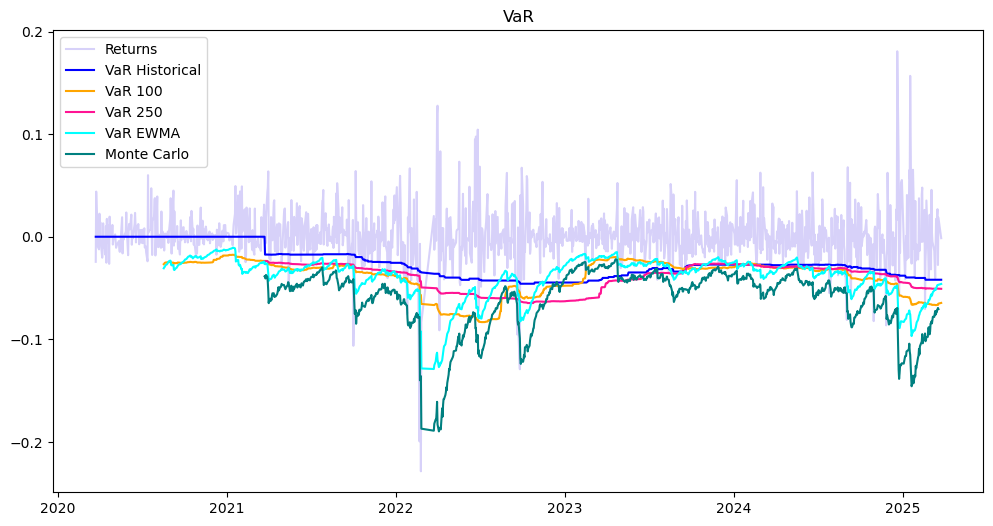

In [373]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Returns'], label = 'Returns', color = 'mediumslateblue', alpha = 0.3)
plt.plot(df['Date'], df['VaR Historical'], label = 'VaR Historical', color = 'b')
plt.plot(df['Date'], df['VaR 100'], label = 'VaR 100', color = 'orange')
plt.plot(df['Date'], df['VaR 250'], label = 'VaR 250', color = 'deeppink')
plt.plot(df['Date'], df['VaR EWMA'], label = 'VaR EWMA', color = 'aqua')
plt.plot(df['Date'], df['monte_carlo_var'], label = 'Monte Carlo', color = 'teal')

plt.legend()
plt.title('VaR')
plt.show()

### Frequency of violations

In [313]:
violations_historical = (df['Returns'] < df['VaR Historical']).sum()
violations_100 = (df['Returns'] < df['VaR 100']).sum()
violations_250 = (df['Returns'] < df['VaR 250']).sum()
violations_ewma = (df['Returns'] < df['VaR EWMA']).sum()
violations_montecarlo = (df['Returns'] < df['monte_carlo_var']).sum()

print(f"Violations for VaR Historical: {violations_historical}")
print(f"Violations for VaR 100 Days: {violations_100}")
print(f"Violations for VaR 250 Days: {violations_250}")
print(f"Violations for VaR EWMA: {violations_ewma}")
print(f"Violations for VaR Monte Carlo: {violations_montecarlo}")

Violations for VaR Historical: 193
Violations for VaR 100 Days: 45
Violations for VaR 250 Days: 53
Violations for VaR EWMA: 44
Violations for VaR Monte Carlo: 14


In [326]:
freq_historical = (violations_historical / len (df['VaR Historical'].dropna())).round(2)
freq_100 = (violations_100 / len (df['VaR 100'].dropna())).round(2)
freq_250 = (violations_250 / len (df['VaR 250'].dropna())).round(2)
freq_ewma = (violations_ewma / len (df['VaR EWMA'].dropna())).round(2)
freq_montecarlo = (violations_montecarlo / len (df['monte_carlo_var'].dropna())).round(2)

print(f"Frequency for VaR Historical: {freq_historical}")
print(f"Frequency for VaR 100 Days: {freq_100}")
print(f"Frequency for VaR 250 Days: {freq_250}")
print(f"Frequency for VaR EWMA: {freq_ewma}")
print(f"Frequency for VaR Monte Carlo: {freq_montecarlo}")

Frequency for VaR Historical: 0.15
Frequency for VaR 100 Days: 0.04
Frequency for VaR 250 Days: 0.05
Frequency for VaR EWMA: 0.04
Frequency for VaR Monte Carlo: 0.01


Монте-Карло самый консервативный, меньше всего violations. Я бы его и предпочла

### Бэктестинг

In [335]:
from scipy.stats import binom

pvalue_historical = (1 - binom.cdf(violations_historical, len (df['VaR Historical'].dropna()),0.05)).round(2)
pvalue_100 = (1 - binom.cdf(violations_100, len (df['VaR 100'].dropna()),0.05)).round(2)
pvalue_250 = (1 - binom.cdf(violations_250, len (df['VaR 250'].dropna()),0.05)).round(2)
pvalue_ewma = (1 - binom.cdf(violations_ewma, len (df['VaR EWMA'].dropna()),0.05)).round(2)
pvalue_montecarlo = (1 - binom.cdf(violations_montecarlo, len (df['monte_carlo_var'].dropna()),0.05)).round(2)

print(f"P-value for VaR Historical: {pvalue_historical}")
print(f"P-value for VaR 100 Days: {pvalue_100}")
print(f"P-value for VaR 250 Days: {pvalue_250}")
print(f"P-value for VaR EWMA: {pvalue_ewma}")
print(f"P-value for VaR Monte Carlo: {pvalue_montecarlo}")

P-value for VaR Historical: 0.0
P-value for VaR 100 Days: 0.95
P-value for VaR 250 Days: 0.31
P-value for VaR EWMA: 0.97
P-value for VaR Monte Carlo: 1.0


p-value < 0,05 -> нулевая гипотеза о том, что количество violations не превышает заданный уровень, отвергается. У P-value for VaR Historical меньше заданного уровня, нерелевантная модель.

У остальных моделей количество violations не превышает заданный уровень

### Additional informal criteria

In [342]:
df_last_252_days = df.tail(252)

violations_historical_last_252 = (df_last_252_days['Returns'] < df_last_252_days['VaR Historical']).sum()
violations_100_last_252 = (df_last_252_days['Returns'] < df_last_252_days['VaR 100']).sum()
violations_250_last_252 = (df_last_252_days['Returns'] < df_last_252_days['VaR 250']).sum()
violations_ewma_last_252 = (df_last_252_days['Returns'] < df_last_252_days['VaR EWMA']).sum()
violations_montecarlo_last_252 = (df_last_252_days['Returns'] < df_last_252_days['monte_carlo_var']).sum()

print(f"Violations for VaR Historical (last 252 days): {violations_historical_last_252}")
print(f"Violations for VaR 100 Days (last 252 days): {violations_100_last_252}")
print(f"Violations for VaR 250 Days (last 252 days): {violations_250_last_252}")
print(f"Violations for VaR EWMA (last 252 days): {violations_ewma_last_252}")
print(f"Violations for VaR Monte Carlo (last 252 days): {violations_montecarlo_last_252}")

Violations for VaR Historical (last 252 days): 26
Violations for VaR 100 Days (last 252 days): 17
Violations for VaR 250 Days (last 252 days): 20
Violations for VaR EWMA (last 252 days): 15
Violations for VaR Monte Carlo (last 252 days): 4


In [366]:
violations_data252 = {
    'Model': ['VaR Historical', 'VaR 100 Days', 'VaR 250 Days', 'VaR EWMA', 'VaR Monte Carlo'],
    'Violations': [
        violations_historical_last_252,
        violations_100_last_252,
        violations_250_last_252,
        violations_ewma_last_252,
        violations_montecarlo_last_252  ]}

df_violations252 = pd.DataFrame(violations_data252)

# функция для определения зоны риска
def determine_zone(violations):
    if violations <= 4:
        return 'Green Zone'
    elif 5 <= violations <= 9:
        return 'Yellow Zone'
    else:
        return 'Red Zone'

df_violations252['Zone'] = df_violations252['Violations'].apply(determine_zone)

# оформление
def highlight_zone(row):
    if row['Zone'] == 'Green Zone':
        return ['background-color: palegreen'] * len(row)
    elif row['Zone'] == 'Yellow Zone':
        return ['background-color: gold'] * len(row)
    elif row['Zone'] == 'Red Zone':
        return ['background-color: lightpink'] * len(row)
    return [''] * len(row)

styled_table = df_violations.style.apply(highlight_zone, axis=1).hide(axis='index')

styled_table

Model,Violations,Zone
VaR Historical,26,Red Zone
VaR 100 Days,17,Red Zone
VaR 250 Days,20,Red Zone
VaR EWMA,15,Red Zone
VaR Monte Carlo,4,Green Zone


Итак, у каждого метода рассчета VaR есть свои плюсы и достоинства

Historical simulation плюсы: понятный, доступный, не надо делать предпосылки о распределении. Минусы: вопрос в том, какой период использовать; кроме того, модели плохо и медленно реагируют на шоки.

Delta-normal плюсы: более гибкие модели, быстрее реагируют на шоки, применимо на более длинные периоды. Минусы: предположение о нормальном распределении, что сильно; не для всех инструментов (например, могут возникнуть сложности с деривативами); сложность вычислений растет нелинейно с ростом количества активов

Монте-Карло плюсы: довольно высокая точность, что мы наблюдали на графиках; применимо для сложных фин инструментов. Минусы: многиими воспринимается как 'black box', сложные расчеты